## Install Libraries & Import Libraries

In [ ]:
!pip install pybboxes

In [ ]:
from pylab import imread, subplot, imshow, show
from IPython.display import clear_output
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image, ImageDraw, ImageFont
import albumentations, os
import numpy as np
import pybboxes as pbx
import torch

In [ ]:
try:
    from google.colab import drive # Load Google Drive files.
    drive.mount('/content/drive', force_remount=True)
    projectPath = '/content/drive/Shareddrives/DeepLearning/FinalProject/'
except ModuleNotFoundError:
    projectPath = os.getcwd() + '/'

In [ ]:
def resizeSample(IMG, bb, resizeTo):
    IMG = np.asarray(IMG)
    transform = albumentations.Compose(
        [albumentations.Resize(height=resizeTo, width=resizeTo, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='coco'))

    transformed = transform(image=IMG, bboxes=bb)

    return transformed

def GetImage(imageID, displayIMG=True, resizeTo=None):
    bbFile = imageID.replace('jpg', 'txt').replace('images', 'labels')

    with open(bbFile, 'r') as file:
        bbFile = file.readlines()
        bbFile = map(lambda x: x.replace('\n', ''), bbFile)
        bbFile = map(lambda x: x.split(' ')[1:], bbFile)
        bbFile = [list(map(int, bb))+[0] for bb in bbFile]

    IMG = Image.open(imageID)

    if resizeTo:
        newSample = resizeSample(IMG, bbFile, resizeTo)
        IMG = Image.fromarray(newSample['image'])
        bbFile = newSample['bboxes']

    if displayIMG:
        fig, ax = plt.subplots()
        ax.imshow(IMG)
        ax.axis('off')

        for rectangle in bbFile:
            x, y, w, h, c = rectangle
            bb = patches.Rectangle((x, y), w, h, linewidth=1, 
                                    edgecolor='r', facecolor='none')
            ax.add_patch(bb)
        plt.show()
    
    return IMG, bbFile

def cleanBoundingBox(toClean):
    cleanedBoxes = []
    for box in toClean:
        box = box.split(' ')
        box = box[:4]
        box = list(map(int, box)) + [0]

        cleanedBoxes.append(box)
    return cleanedBoxes

## YOLO Dataset Creation

In [ ]:
imagesPath = projectPath+'DefaultData/Train/images/' # Raw Images
boundingBoxesFile = projectPath+'DefaultData/Train/Labels/BoundingBoxes.txt'
resultsTrain = projectPath+'DATA/WIDER_TRAIN/'

In [ ]:
imagesPath = projectPath+'DefaultData/Validation/images/' # Raw Images
boundingBoxesFile = projectPath+'DefaultData/Validation/Labels/BoundingBoxes.txt'
resultsTrain = projectPath+'DATA/WIDER_VALIDATION/'

In [ ]:
bbFile = open(boundingBoxesFile).readlines()
folderNames, folders = os.listdir(imagesPath), len(os.listdir(imagesPath))
resizeTo = 1280
Counter = 0 # Counter of loaded images.
Skipped = 0
for folder in folderNames:
    imageNames = os.listdir(imagesPath+folder)
    for image in imageNames:
        imageName = imagesPath + folder + '/' + image
        IMG = Image.open(imageName)
        imgSize = IMG.size

        searchFor = folder + '/' + image + '\n' # Bounding Box Search
        i = bbFile.index(searchFor)
        numFaces = int(bbFile[i+1])+1
        boundingBoxes = bbFile[i+2:(i+1)+numFaces] # Raw + COCO Format
        boundingBoxes = cleanBoundingBox(boundingBoxes) # COCO Format
        try:
            newSample = resizeSample(IMG, boundingBoxes, resizeTo)
        except ValueError:
            Skipped += 1
        else:
            IMG = Image.fromarray(newSample['image'])
            boundingBoxes = newSample['bboxes']
            imgSize = IMG.size

            bbsYOLO = []
            for rectangle in boundingBoxes:
                bbox = rectangle[:-1] # Last position contains the class.
    
                bbYOLO = pbx.convert_bbox(bbox, from_type="coco", to_type="yolo", 
                                        image_width=imgSize[0], 
                                        image_height=imgSize[1])
                

                bbYOLO = list(bbYOLO) # Convert Tuple to List
                bbsYOLO.append(bbYOLO)

            bbFilePath = resultsTrain + 'labels/'
            with open(bbFilePath+image.replace('jpg', 'txt'), 'w') as file:
                for bb in bbsYOLO:
                    bb = str(bb).replace('[', '').replace(']', '').replace(',', '')
                    file.write('0 ')
                    file.write(bb+'\n')

            IMG.save(resultsTrain + 'images/' + image)

            Counter += 1
            if Counter%500 == 0:
                clear_output(wait=True)
                print(f"Image {Counter}")

clear_output(wait=True)
print(f"Loaded {Counter} Images")

## YOLO v5 Installation & Training

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install wandb

In [ ]:
!python yolov5/train.py --img 1280 --batch 16 --epochs 3 --data /content/drive/Shareddrives/DeepLearning/FinalProject/DATA/WIDER.yaml --weights yolov5s.pt --device 0

In [ ]:
!python yolov5/export.py --weights yolov5/runs/train/exp/weights/best.pt

## Load & Test Model

In [ ]:
MyModel = torch.hub.load('ultralytics/yolov5', 'custom', projectPath+'Models/YOLO/Best.onnx', _verbose=False)
MyModel.cuda()

In [ ]:
IMG = Image.open(projectPath+'DATA/WIDER_TEST/Image9.jpg')
FaceDetections = MyModel(IMG).pandas().xyxy[0]

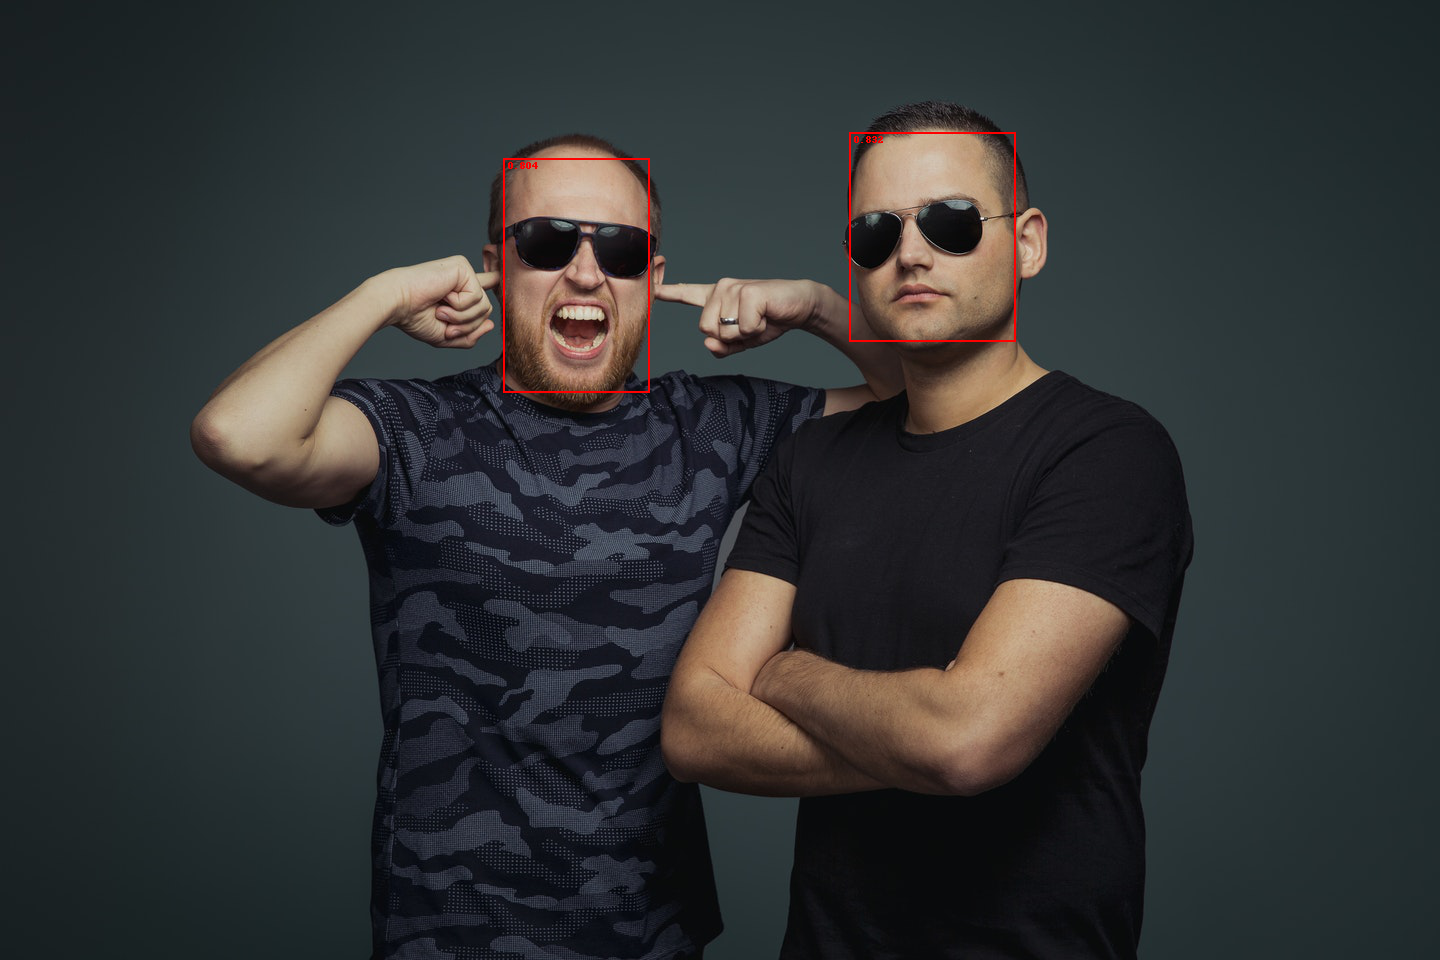

In [ ]:
for detection in FaceDetections.values:
    xmin, ymin, xmax, ymax, confidence = detection[:5]
    if confidence >= 0.50:
        bb = [(xmin, ymin), (xmax, ymax)]
        w = xmax - xmin
        IMG_ = ImageDraw.Draw(IMG)
        IMG_.rectangle(bb, outline ="Red", width=2)

        Text = ImageDraw.Draw(IMG)
        Text.text((xmin+5, ymin+2), str(round(confidence, 3)), fill=(255, 0, 0))
IMG

## Test Model

In [ ]:
def extractFace(IMG, FaceDetector, threshold=0.50):
    extractedFaces = []
    W, H = IMG.size
    FaceDetections = FaceDetector(IMG).pandas().xyxy[0]
    for detection in FaceDetections.values:
        xmin, ymin, xmax, ymax, confidence = detection[:5]
        if confidence >= threshold:
            bb = [xmin/W, ymin/H, xmax/W, ymax/H]
            extractedFaces.append(bb)

    return extractedFaces

In [ ]:
testData = projectPath+'DATA/COCO2017_TEST'

In [ ]:
difference = []
n = len(os.listdir(testData + '/' + 'Images'))
i = 0
for imageName in os.listdir(testData + '/' + 'Images'):
    imagePath = testData + '/Images/' + imageName
    labelPath = testData + '/Labels/' + imageName.replace('jpg', 'txt')

    with open(labelPath, 'r') as file:
        realData = file.readlines()
        realData = map(lambda x: x.replace('\n', ''), realData)
        realData = map(lambda x: x.split(' '), realData)
        realData = map(lambda x: list(map(float, x)), realData)
        realData = filter(lambda x: x[0]==0, realData)
        realData = map(lambda x: x[1:], realData)
        realData = list(realData)
    
    IMG = Image.open(imagePath)
    yoloData = extractFace(IMG, MyModel, 0.40)

    for x in zip(realData, yoloData):
        bbr, bbp = x
        bbr, bbp = np.array(bbr), np.array(bbp)
        df = np.abs(bbr - bbp).mean()
        difference.append(df)
    
    i += 1
    if i%25 == 0:
        clear_output(wait=True)
        print(f"Image {i} / {n}")

df = sum(difference)/len(difference)
print(1-df)

In [ ]:
print(f"Test Accuracy: {round((1-df)*100, 2)}%")

Test Accuracy: 74.65%
